In [6]:
from backtest import *
from price_sim import *
import warnings
warnings.filterwarnings("ignore")

# 1) 每周选“上周收益最高”的前 N（动量）
def weekly_winners(signal_date, data_view, top_n=10, freq="W-FRI"):
    close_hist = data_view["close"]
    weekly_close = close_hist.resample(freq).last()
    last_fri = weekly_close.index[weekly_close.index <= signal_date].max()
    prev_fri = weekly_close.index[weekly_close.index < last_fri].max() if pd.notna(last_fri) else None
    if pd.isna(last_fri) or pd.isna(prev_fri): return pd.Series(0.0, index=close_hist.columns)
    wk = (weekly_close.loc[last_fri]/weekly_close.loc[prev_fri] - 1).dropna()
    picks = wk.nlargest(top_n).index
    w = pd.Series(0.0, index=close_hist.columns)
    if len(picks): w.loc[picks] = 1/len(picks)
    return w

# 2) 每周选“上周跌得最多”的前 N（反转）
def weekly_losers(signal_date, data_view, top_n=10, freq="W-FRI"):
    close_hist = data_view["close"]
    weekly_close = close_hist.resample(freq).last()
    last_fri = weekly_close.index[weekly_close.index <= signal_date].max()
    prev_fri = weekly_close.index[weekly_close.index < last_fri].max() if pd.notna(last_fri) else None
    if pd.isna(last_fri) or pd.isna(prev_fri): return pd.Series(0.0, index=close_hist.columns)
    wk = (weekly_close.loc[last_fri]/weekly_close.loc[prev_fri] - 1).dropna()
    picks = wk.nsmallest(top_n).index
    w = pd.Series(0.0, index=close_hist.columns)
    if len(picks): w.loc[picks] = 1/len(picks)
    return w

# 3) 每周选“排名第 5/6/7 名”
def weekly_rank_567(signal_date, data_view, k1=4, k2=7, freq="W-FRI"):
    close_hist = data_view["close"]
    weekly_close = close_hist.resample(freq).last()
    last_fri = weekly_close.index[weekly_close.index <= signal_date].max()
    prev_fri = weekly_close.index[weekly_close.index < last_fri].max() if pd.notna(last_fri) else None
    if pd.isna(last_fri) or pd.isna(prev_fri): return pd.Series(0.0, index=close_hist.columns)
    wk = (weekly_close.loc[last_fri]/weekly_close.loc[prev_fri] - 1).dropna()
    if len(wk) < k2: return pd.Series(0.0, index=close_hist.columns)
    ranked = wk.sort_values(ascending=False)  # 1=最好
    picks = ranked.iloc[k1-1:k2].index        # 取第 5..7
    w = pd.Series(0.0, index=close_hist.columns)
    if len(picks): w.loc[picks] = 1/len(picks)
    return w


open_px, close_px, universe, calendar = simulate_prices(
    n_names=100,
    bdays=252,
    seed=2025,
    model="gbm_jumps",      # 'gbm' / 'gbm_jumps' / 'sv'
    equicorr=0.4,
    jump_intensity=2.0,     # 年化 2 次跳跃
    jump_mean=-0.03,
    jump_std=0.06,
)

# 3) 跑回测
res = backtest(
    open_px=open_px,
    close_px=close_px,
    universe=universe,
    start=str(calendar[0].date()),
    end=str(calendar[-1].date()),
    strategy_fn=weekly_winners,
    rebalance_rule="W-FRI",
    fee_bps=5.0,
    slip_bps=10.0,
    initial_capital=1_000_000.0,
)

print(res["metrics"])

{'CAGR': 0.03130981619943496, 'Vol_Ann': 0.1991432077040979, 'Sharpe_Ann': 0.2540175808830072, 'MaxDD': -0.13700304210794811, 'Rebalances': 50, 'Fees_$': 40866.60917316586, 'Turnover_$': 81733218.3463317}


{'CAGR': 0.33869605070613984, 'Vol_Ann': 0.17542813001408922, 'Sharpe_Ann': 1.750847635650276, 'MaxDD': -0.13124482208027077, 'Rebalances': 50, 'Fees_$': 50472.31744359176, 'Turnover_$': 100944634.8871835}


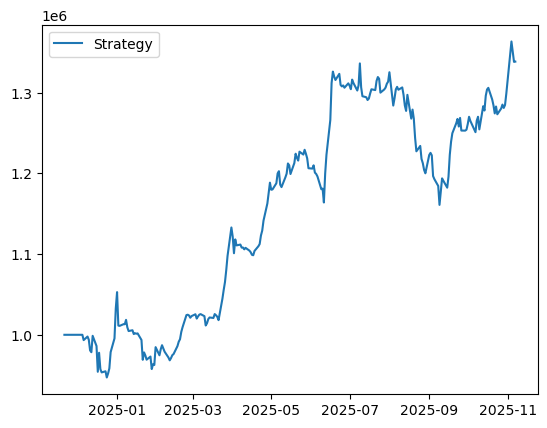

In [8]:
# 假设你已有 open_px / close_px（索引为交易日 DatetimeIndex，列为股票代码）
# universe = list(close_px.columns)
# start, end = "2024-11-20", "2025-11-07"

res = backtest(
    open_px=open_px,
    close_px=close_px,
    universe=universe,
    start="2024-11-20",
    end="2025-11-07",
    strategy_fn=weekly_losers,   # 换成 weekly_winners / weekly_losers 即可
    rebalance_rule="W-FRI",
    fee_bps=5.0,
    slip_bps=10.0,
    initial_capital=1_000_000.0,
    allow_short=False,
    leverage_limit=1.0,
    max_weight=0.5,
    round_lot=1,
    min_trade_value=0.0,
)

print(res["metrics"])          # 指标（CAGR/Sharpe/MaxDD/换手等）
equity = res["equity"]         # 净值曲线（pd.Series）
trades = res["trades"]         # 交易日志（list of dict）
holds  = res["holdings"]       # 每期目标权重记录（list of dict）

# 画个图（可选）
import matplotlib.pyplot as plt
plt.figure(); plt.plot(equity.index, equity.values, label="Strategy"); plt.legend(); plt.show()
